# Import Necessary Library and Some Useful Method

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE

import itertools
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from sklearn.ensemble import RandomForestClassifier

RSEED = 1994

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

def calculate_sensitivity_specificity(y_test, y_pred_test):
    # Note: More parameters are defined than necessary. 
    # This would allow return of other measures other than sensitivity and specificity
    
    # Get true/false for whether a breach actually occurred
    actual_pos = y_test == 1
    actual_neg = y_test == 0
    
    # Get true and false test (true test match actual, false tests differ from actual)
    true_pos = (y_pred_test == 1) & (actual_pos)
    false_pos = (y_pred_test == 1) & (actual_neg)
    true_neg = (y_pred_test == 0) & (actual_neg)
    false_neg = (y_pred_test == 0) & (actual_pos)
    
    # Calculate accuracy
    accuracy = np.mean(y_pred_test == y_test) * 100
    
    # Calculate sensitivity and specificity
    sensitivity = np.sum(true_pos) / np.sum(actual_pos) * 100
    specificity = np.sum(true_neg) / np.sum(actual_neg) * 100
    
    return sensitivity, specificity, accuracy

def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

# Dataset Information and Drop All Feature Engineering
(Without Feature Engineering Experiment)

In [3]:
df = pd.read_csv("./Dataset/FeatureEngineeredData.csv")
df = df.drop(['PDATE','PONO','MIXNO','BATCHNO','M1T10','M1T90','M1ML','M1MH','Hard','T10RE','T90RE','D2MNRE','D2MN','HardRE'], axis=1)
df = df.drop(['ram_closedtime','ram_closedtimemax','ram_opentime','ram_opentimemax'], axis=1)
df = df.drop(['temp_avg_when_ram_closed','temp_avg_when_ram_open','temp_max_when_ram_closed','temp_max_when_ram_open','temp_max_minus_min_when_ram_closed','tempinc_avg_when_ram_closed','heat_flux_when_ram_all','heat_flux_when_ram_closed','heat_flux_when_ram_open'], axis=1)
df = df.drop(['tempinc_max_when_ram_closed','volt_avg_when_ram_closed','volt_avg_when_ram_open','volt_max_when_ram_closed','volt_max_when_ram_open','volt_max_minus_min','physics_flux_all','physics_flux_when_ram_closed','physics_flux_when_ram_open'], axis=1)

In [4]:
#LABELING
df["RESULT"] = df["RESULT"].astype('category')
df["RESULT"] = df["RESULT"].cat.codes

In [5]:
#Data Without Feature Engineering
df

,RESULT,ram_count_closed,temp_avg_all,volt_avg_all
0,0,5,78.855090,121.808383
1,0,5,81.124332,109.047478
2,0,5,82.660182,114.595745
3,0,5,82.365015,114.876161
4,0,5,87.455108,117.934985
...,...,...,...,...
2909,1,5,60.531579,185.958947
2910,1,5,64.655527,169.270951
2911,1,5,66.239362,167.594681
2912,1,5,65.887728,174.090862


Number of numerical columns with no nan values : 4
Number of nun-numerical columns with no nan values : 0


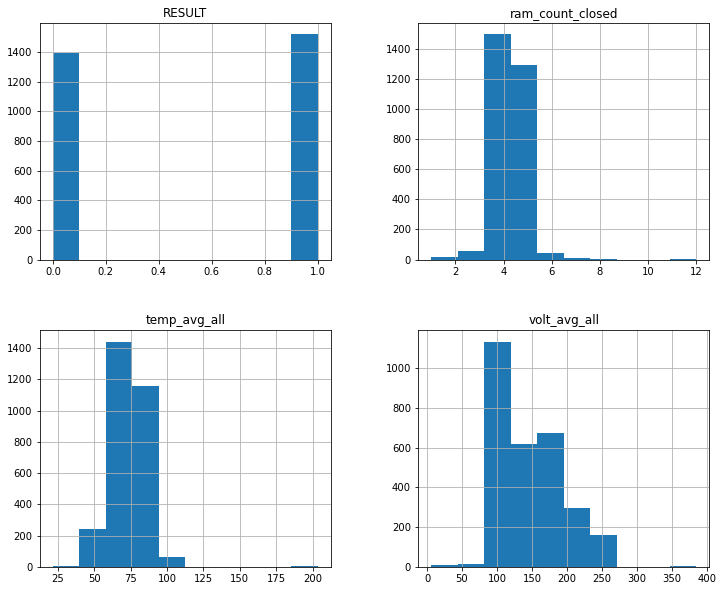

In [6]:
num_cols = get_cols_with_no_nans(df , 'num')
cat_cols = get_cols_with_no_nans(df , 'no_num')
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))
df = df[num_cols + cat_cols]
df.hist(figsize = (12,10))
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(df.pop('RESULT'))

# Saving feature names for later use
feature_list = df.columns
# Convert to numpy array
features = np.array(df)

# 30% examples in test data
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, test_size = 0.30, random_state = RSEED)

In [8]:
# fit model to training data
model = RandomForestClassifier(max_depth=10, random_state=RSEED)
model.fit(train_features, train_labels)
# make predictions for test data
y_pred = model.predict(test_features)
predictions = [round(value) for value in y_pred]

# [EXPERIMENT 1] [Random Forest] Without Feature Engineering

Confusion matrix, without normalization
[[383  47]
 [ 64 381]]
Accuracy: 87.31%
sensitivity: 85.62%
Precision: 89.07%
F1-score: 87.29%


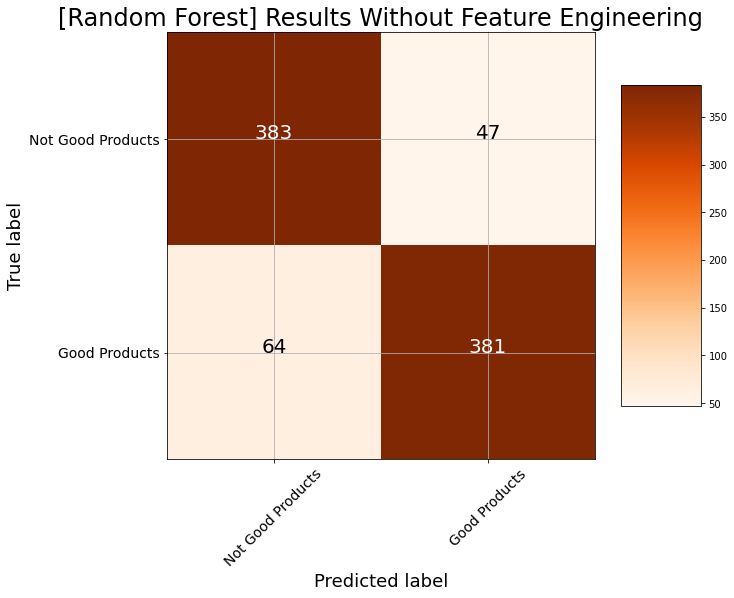

In [9]:
calculate_sensitivity_specificity(test_labels, y_pred)
cm = confusion_matrix(test_labels, y_pred)
plot_confusion_matrix(cm, classes = ['Not Good Products', 'Good Products'],
                      title = '[Random Forest] Results Without Feature Engineering')
accuracy = accuracy_score(test_labels, y_pred)
recall = recall_score(test_labels, y_pred)
precision = precision_score(test_labels, y_pred)
sensitivity = calculate_sensitivity_specificity(test_labels, y_pred)[0]
specificity = calculate_sensitivity_specificity(test_labels, y_pred)[1]
F1 = 2 * (precision * recall) / (precision + recall)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("sensitivity: %.2f%%" % (sensitivity))
print("Precision: %.2f%%" % (specificity))
print("F1-score: %.2f%%" % (F1 * 100.0))

# Implementation of SMOTE

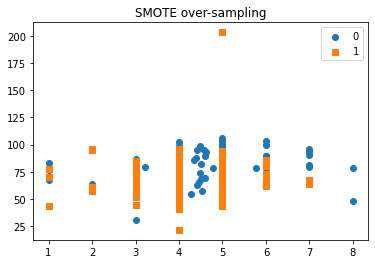

array([1073, 1073], dtype=int64)

In [10]:
smote = SMOTE(sampling_strategy='minority', random_state=RSEED)
train_features_smote, train_labels_smote = smote.fit_resample(train_features, train_labels)

plot_2d_space(train_features_smote, train_labels_smote, 'SMOTE over-sampling')
unique_elements, counts_elements = np.unique(train_labels_smote, return_counts=True)
counts_elements

In [11]:
# fit model no training data
model = RandomForestClassifier(max_depth=10, random_state=RSEED)
model.fit(train_features_smote, train_labels_smote)
# make predictions for test data
y_pred = model.predict(test_features)
predictions = [round(value) for value in y_pred]

# [EXPERIMENT 2] [Random Forest] Without Feature Engineering + SMOTE

Confusion matrix, without normalization
[[385  45]
 [ 60 385]]
Accuracy: 88.00%
Recall: 86.52%
Precision: 89.53%
F1: 88.00%


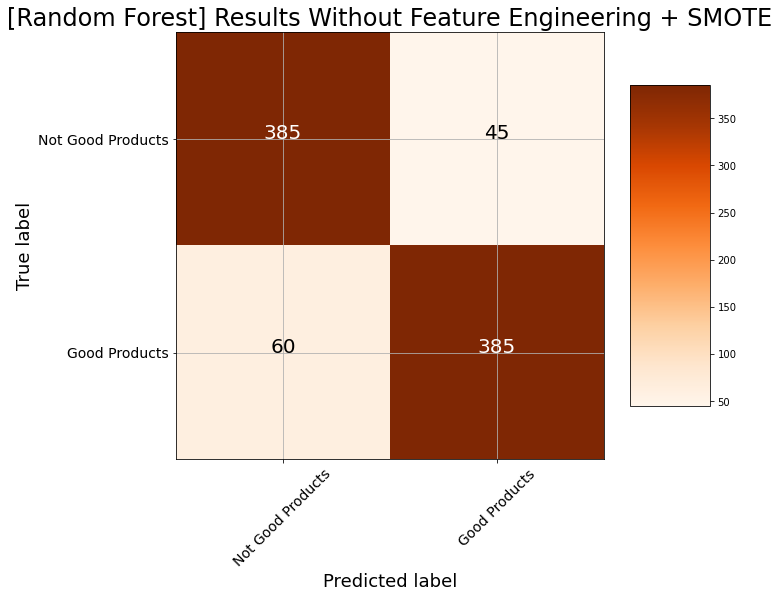

In [12]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, classes = ['Not Good Products', 'Good Products'],
                      title = '[Random Forest] Results Without Feature Engineering + SMOTE')
accuracy = accuracy_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
F1 = 2 * (precision * recall) / (precision + recall)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("F1: %.2f%%" % (F1 * 100.0))